# 6. Model Building, Tuning, Training and Validation
* File: `train_model.ipynb`
* **Purpose**: To build various machine learning models and prepare them for evaluation.

* Steps:

    * _Model Implementation_: Train multiple models (e.g., Logistic Regression, Decision Tree, Random Forest).
    * _Hyperparameter Tuning_: Use GridSearchCV or RandomizedSearchCV for tuning.
    * _Cross-Validation_: Implement cross-validation for model robustness.
    * _Model Validation_: Generate the classification report and model metrics to signify model performance.
    * _Compare Model Performance_
                                                                     

## 6.1 Import libraries and load the data

In [1]:
# Import libraries

# Data manipulation
import numpy as np  # Array and matrix operations
import pandas as pd  # DataFrame handling
import matplotlib.pyplot as plt # A library used for creating static, interactive, and animated visualizations in Python
import seaborn as sns # A data visualization library based on matplotlib; provides a high-level interface for drawing and for statistical graphics

# Model selection and evaluation
from sklearn.model_selection import train_test_split  # Splitting data into training and testing sets
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold  # Hyperparameter tuning and cross-validation

# Data preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder  # Feature scaling, polynomial features, and label encoding
from imblearn.over_sampling import SMOTE  # Handling class imbalance using SMOTE

# Classification models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier  # Ensemble classifiers
from sklearn.linear_model import LogisticRegression  # Logistic regression model
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.tree import DecisionTreeClassifier  # Decision Tree classifier
from xgboost import XGBClassifier  # XGBoost classifier
from sklearn.neural_network import MLPClassifier  # Neural network-based classifier
from sklearn.neighbors import KNeighborsClassifier  # k-Nearest Neighbors classifier

# Dimensionality reduction
from sklearn.decomposition import PCA  # Principal Component Analysis

# Model evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # Accuracy, confusion matrix, and classification report


In [2]:
# Load cleaned and transformed data
# df = pd.read_csv('../../data/processed/selecteddata.csv')
import os

current_dir = os.getcwd()
df = pd.read_csv(os.path.join(current_dir, "../../data/processed/selecteddata.csv"))
df.head(2)

## 6.2 Data Preparation
* Load and Preprocess Data: The comment indicates that data loading and preprocessing should be done before this point. 
* The data variable should be a pandas DataFrame containing your dataset.

In [3]:
# Separate features and target
X = df.drop(['Target'], axis=1)
y = df['Target']

* X: Contains all features except the target variable PerformanceRating.
* y: Contains only the target variable PerformanceRating.

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


* Splits the dataset into training and testing sets.
    * test_size=0.3: 30% of the data is used for testing.
    * random_state=42: Ensures reproducibility of the split.

## 6.3 Model Building, Training and Validation

### 6.3.1 Logistic Regression
* The logistic regression model was developed to predict an ordinal target variable with three levels (2, 3, and 4).
* The process involved several key steps: scaling the features using StandardScaler, generating polynomial features to capture non-linear relationships, and addressing class imbalance with SMOTE.
* The data was split into training and testing sets, and stratified cross-validation was used for consistent evaluation.
* Hyperparameter tuning was performed using grid search, resulting in a model with optimized parameters (C: 10, penalty: 'l1', solver: 'saga').
* The final model achieved an accuracy of 88.8%, with high precision and recall across all classes, particularly for the highest performance rating (class 4).
* The model's strong performance metrics indicate its suitability for deployment in predicting employee performance ratings. Key metrics were saved for comparison with other models.

In [5]:
# Logistic Regression

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Handle Imbalanced Data with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_poly, y)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Set up Stratified Cross-Validation
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Hyperparameter Tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2']
}

logistic_model = LogisticRegression(max_iter=2000, random_state=42)  # Increased max_iter
grid_search = GridSearchCV(logistic_model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred_logistic = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_logistic)
conf_matrix = confusion_matrix(y_test, y_pred_logistic)
class_report = classification_report(y_test, y_pred_logistic, output_dict=True)
best_params = grid_search.best_params_

# Print model metrics
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logistic))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logistic))
print("Classification Report:\n", classification_report(y_test, y_pred_logistic))
print("Best Parameters:", grid_search.best_params_)

# Save topline metrics for Logistic Regression
logistic_metrics = {
    'Model': 'Logistic Regression',
    'Accuracy': accuracy,
    'Precision': class_report['macro avg']['precision'],
    'Recall': class_report['macro avg']['recall'],
    'F1-Score': class_report['macro avg']['f1-score']
}

Logistic Regression Accuracy: 0.8881829733163914
Confusion Matrix:
 [[250  25   3]
 [ 20 200  30]
 [  0  10 249]]
Classification Report:
               precision    recall  f1-score   support

           2       0.93      0.90      0.91       278
           3       0.85      0.80      0.82       250
           4       0.88      0.96      0.92       259

    accuracy                           0.89       787
   macro avg       0.89      0.89      0.89       787
weighted avg       0.89      0.89      0.89       787

Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}


### 6.3.2 Support Vector Classifier (SVC)
* The Support Vector Classifier (SVC) was employed to predict an ordinal target variable.
* The process began with feature scaling using StandardScaler, followed by the optional addition of polynomial features to capture non-linear interactions.
* SMOTE was used to address class imbalance. After splitting the data into training and testing sets, hyperparameter tuning was performed using grid search with stratified cross-validation, testing various values for C, gamma, and kernel types.
* The best model was found with parameters C: 100, gamma: 0.01, and kernel: 'rbf', achieving an accuracy of 93.3%.
* The model showed strong performance across all classes, particularly in precision and recall for the highest rating (class 4).
* The accuracy and other key metrics were saved for comparison.

In [6]:
# Support Vector Classifier (SVC)

# Step 1: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Add Polynomial Features (Optional, for non-linear interactions)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Step 3: Handle Imbalanced Data with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_poly, y)

# Step 4: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Step 5: Hyperparameter Tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

svc_model = SVC(random_state=42)
grid_search = GridSearchCV(svc_model, param_grid, refit=True, verbose=3, cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True), n_jobs=-1)
grid_search.fit(X_train, y_train)

# Step 6: Best Model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred_svc = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_svc)
conf_matrix = confusion_matrix(y_test, y_pred_svc)
class_report = classification_report(y_test, y_pred_svc, output_dict=True)
best_params = grid_search.best_params_

# Print the model metrics
print("SVC Accuracy:", accuracy_score(y_test, y_pred_svc))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svc))
print("Classification Report:\n", classification_report(y_test, y_pred_svc))
print("Best Parameters:", grid_search.best_params_)

# Save topline model metrics for SVC
svc_metrics = {
    'Model': 'SVC',
    'Accuracy': accuracy,
    'Precision': class_report['macro avg']['precision'],
    'Recall': class_report['macro avg']['recall'],
    'F1-Score': class_report['macro avg']['f1-score']
}


Fitting 5 folds for each of 75 candidates, totalling 375 fits
SVC Accuracy: 0.9326556543837357
Confusion Matrix:
 [[264  13   1]
 [ 13 216  21]
 [  1   4 254]]
Classification Report:
               precision    recall  f1-score   support

           2       0.95      0.95      0.95       278
           3       0.93      0.86      0.89       250
           4       0.92      0.98      0.95       259

    accuracy                           0.93       787
   macro avg       0.93      0.93      0.93       787
weighted avg       0.93      0.93      0.93       787

Best Parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


### 6.3.3 Decision Tree
* A Decision Tree classifier was implemented to predict an ordinal target variable. 
* The process began with feature scaling using StandardScaler, followed by the optional addition of polynomial features for non-linear interactions.
* SMOTE was applied to address class imbalance. The data was then split into training and testing sets.
* GridSearchCV was used for hyperparameter tuning, testing various combinations of max_depth, min_samples_split, min_samples_leaf, max_features, and criterion. The best model, with criterion: 'gini', max_depth: 5, and min_samples_leaf: 4, achieved an accuracy of 94.7%.
* The model demonstrated high precision, recall, and F1-scores across all classes. The accuracy and other key metrics were saved for future comparison.

In [7]:
# Decision Tree

# Step 1: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Add Polynomial Features (Optional)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Step 3: Handle Imbalanced Data with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_poly, y)

# Step 4: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Step 5: Hyperparameter Tuning using GridSearchCV
param_grid = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

decision_tree_model = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(decision_tree_model, param_grid, refit=True, verbose=3, cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True), n_jobs=-1)
grid_search.fit(X_train, y_train)

# Step 6: Best Model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred_tree = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_tree)
conf_matrix = confusion_matrix(y_test, y_pred_tree)
class_report = classification_report(y_test, y_pred_tree, output_dict=True)
best_params = grid_search.best_params_

# Print the model metrics
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))
print("Classification Report:\n", classification_report(y_test, y_pred_tree))
print("Best Parameters:", grid_search.best_params_)

# Save topline metrics for Decision Tree
tree_metrics = {
    'Model': 'Decision Tree',
    'Accuracy': accuracy,
    'Precision': class_report['macro avg']['precision'],
    'Recall': class_report['macro avg']['recall'],
    'F1-Score': class_report['macro avg']['f1-score']
}



Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Decision Tree Accuracy: 0.9466327827191868
Confusion Matrix:
 [[265  13   0]
 [  7 236   7]
 [  3  12 244]]
Classification Report:
               precision    recall  f1-score   support

           2       0.96      0.95      0.96       278
           3       0.90      0.94      0.92       250
           4       0.97      0.94      0.96       259

    accuracy                           0.95       787
   macro avg       0.95      0.95      0.95       787
weighted avg       0.95      0.95      0.95       787

Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}


### 6.3.4 XGBoost 
* An XGBoost classifier was employed to enhance prediction accuracy. The process started with scaling features using StandardScaler and encoding the target variable with LabelEncoder.
* The dataset was split into training and testing sets. RandomizedSearchCV was utilized for hyperparameter optimization, exploring parameters such as n_estimators, max_depth, learning_rate, subsample, and colsample_bytree.
* The best parameters were subsample: 0.8, n_estimators: 500, max_depth: 3, learning_rate: 0.01, and colsample_bytree: 1.0, achieving a validation accuracy of 94.0%.
* The best model predicted with an accuracy of 92.5% on the test set. The classification report highlighted high precision, recall, and F1-scores across classes. These metrics and the best parameters were documented for future reference.

In [8]:
# XGBoost

# Step 1: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='mlogloss'),
    param_distributions=param_distributions,
    n_iter=50,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train_encoded)

# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)

# Use the best estimator for predictions
xgb_model = random_search.best_estimator_

# Predict on the test set
y_pred_xgb_encoded = xgb_model.predict(X_test)

# Convert predictions back to original labels
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb_encoded)

# Convert test labels back to original labels
y_test = label_encoder.inverse_transform(y_test_encoded)

# Model Metrics
accuracy = accuracy_score(y_test, y_pred_xgb)
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
class_report = classification_report(y_test, y_pred_xgb, output_dict=True)

# Print the model metrics
print("XGBoost Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Best Parameters:", random_search.best_params_)

# Save topline metrics for XGBoost
xgb_metrics = {
    'Model': 'XGBoost',
    'Accuracy': accuracy,
    'Precision': class_report['macro avg']['precision'],
    'Recall': class_report['macro avg']['recall'],
    'F1-Score': class_report['macro avg']['f1-score']
}


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found:  {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Best score found:  0.9404761904761904
XGBoost Accuracy: 0.925
Classification Report:
               precision    recall  f1-score   support

           2       0.86      0.88      0.87        49
           3       0.94      0.96      0.95       268
           4       0.91      0.74      0.82        43

    accuracy                           0.93       360
   macro avg       0.90      0.86      0.88       360
weighted avg       0.92      0.93      0.92       360

Confusion Matrix:
 [[ 43   6   0]
 [  7 258   3]
 [  0  11  32]]
Best Parameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}


### 6.3.5 Gradient Boosting
* The Gradient Boosting Classifier was utilized to improve prediction accuracy.
* The process began with feature scaling using StandardScaler, followed by splitting the data into training and testing sets. A parameter grid was defined for RandomizedSearchCV, including hyperparameters such as n_estimators, learning_rate, max_depth, and others.
* The RandomizedSearchCV was run with 20 iterations and 5-fold cross-validation. The best parameters identified were subsample: 0.9, n_estimators: 200, min_samples_split: 5, min_samples_leaf: 1, max_features: None, max_depth: 3, and learning_rate: 0.01, achieving a validation score of approximately 94.5%
* The model was then trained and evaluated on the test set, achieving an accuracy of 91.7%. The classification report revealed strong performance, particularly high precision, recall, and F1-scores for the majority class. The results and best parameters were recorded for future reference.

In [9]:
# Gradient Boosting

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Define a simplified parameter grid
param_distributions = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 0.9,],
    'max_features': [None, 'sqrt']
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=param_distributions,
    n_iter=20,  # Reduced number of iterations
    scoring='accuracy',
    cv=5,  # Cross-validation folds
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)

# Use the best estimator
gb_model = random_search.best_estimator_

# Train and evaluate with selected features (skip feature selection for now)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# Model Metrics
accuracy = accuracy_score(y_test, y_pred_gb)
conf_matrix = confusion_matrix(y_test, y_pred_gb)
class_report = classification_report(y_test, y_pred_gb, output_dict=True)
best_params = grid_search.best_params_

# Print the model metrics
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))
print("Classification Report:\n", classification_report(y_test, y_pred_gb))

# Save top metrics for Gradient Boosting
gb_metrics = {
    'Model': 'Gradient Boosting',
    'Accuracy': accuracy,
    'Precision': class_report['macro avg']['precision'],
    'Recall': class_report['macro avg']['recall'],
    'F1-Score': class_report['macro avg']['f1-score']
}

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'subsample': 0.9, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 3, 'learning_rate': 0.01}
Best score found:  0.9452380952380952
Gradient Boosting Accuracy: 0.9166666666666666
Confusion Matrix:
 [[ 41   8   0]
 [  9 258   1]
 [  0  12  31]]
Classification Report:
               precision    recall  f1-score   support

           2       0.82      0.84      0.83        49
           3       0.93      0.96      0.95       268
           4       0.97      0.72      0.83        43

    accuracy                           0.92       360
   macro avg       0.91      0.84      0.87       360
weighted avg       0.92      0.92      0.92       360



### 6.3.6 Artificial Neural Network (Multilayer Perceptron - MLP)
* Artificial Neural Network (MLP):
    * The MLP model underwent several preprocessing steps: feature scaling with StandardScaler, dimensionality reduction via PCA (to retain 95% of variance), and handling class imbalance using SMOTE.
    * After applying hyperparameter tuning through grid search, the best configuration was found to be {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (150, 100), 'learning_rate': 'constant', 'solver': 'adam'}.
    * This MLP model achieved an impressive accuracy of 95.6%. The confusion matrix indicated high precision and recall for most classes, with a classification report showing strong performance across all metrics.

* Bagging MLP:
    * The Bagging MLP model, which utilized the best MLP configuration from the grid search as the base estimator, yielded a slightly lower accuracy of 95.2%. Despite this, the Bagging approach improved robustness and stability.
    * The confusion matrix and classification report showed that the Bagging MLP model performed exceptionally well, with particularly high precision and recall for the majority class.

* Overall:
    * Both models demonstrated excellent performance. The MLP model showed marginally higher accuracy, while the Bagging MLP provided improved robustness. The metrics highlight their effectiveness in classification tasks and their capability to handle different classes effectively.

In [10]:
# Artificial Neural Network (Multilayer Perceptron - MLP)

# Step 1: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Dimensionality Reduction (PCA)
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Step 3: Handling Imbalance (SMOTE)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pca, y)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Step 5: Hyperparameter Tuning with GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 100)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
    'alpha': [0.0001, 0.001, 0.01]
}

grid_search = GridSearchCV(MLPClassifier(max_iter=1000, random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Step 6: Evaluate the best model
best_mlp = grid_search.best_estimator_
y_pred_mlp = best_mlp.predict(X_test)

print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

print("ANN (MLP) Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_mlp))
print("Classification Report:\n", classification_report(y_test, y_pred_mlp))

# Step 7: Ensemble Method (Bagging)
bagging_mlp = BaggingClassifier(MLPClassifier(hidden_layer_sizes=grid_search.best_params_['hidden_layer_sizes'],
                                              activation=grid_search.best_params_['activation'],
                                              solver=grid_search.best_params_['solver'],
                                              learning_rate=grid_search.best_params_['learning_rate'],
                                              alpha=grid_search.best_params_['alpha'],
                                              max_iter=1000,
                                              random_state=42),
                                n_estimators=10, random_state=42, n_jobs=-1)
bagging_mlp.fit(X_train, y_train)
y_pred_bagging = bagging_mlp.predict(X_test)

# Model Metrics
accuracy = accuracy_score(y_test, y_pred_bagging)
conf_matrix = confusion_matrix(y_test, y_pred_bagging)
class_report = classification_report(y_test, y_pred_bagging, output_dict=True)
best_params = grid_search.best_params_

# Print the model metrics
print("Bagging MLP Accuracy:", accuracy_score(y_test, y_pred_bagging))
print("Bagging MLP Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bagging))
print("Bagging MLP Classification Report:\n", classification_report(y_test, y_pred_bagging))

# Save top metrics for MLP
mlp_metrics = {
    'Model': 'MLP',
    'Accuracy': accuracy,
    'Precision': class_report['macro avg']['precision'],
    'Recall': class_report['macro avg']['recall'],
    'F1-Score': class_report['macro avg']['f1-score']
}



Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters found:  {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (150, 100), 'learning_rate': 'constant', 'solver': 'adam'}
Best score found:  0.9542234332425068
ANN (MLP) Accuracy: 0.9555273189326556
Confusion Matrix:
 [[271   6   1]
 [ 16 228   6]
 [  1   5 253]]
Classification Report:
               precision    recall  f1-score   support

           2       0.94      0.97      0.96       278
           3       0.95      0.91      0.93       250
           4       0.97      0.98      0.97       259

    accuracy                           0.96       787
   macro avg       0.96      0.95      0.96       787
weighted avg       0.96      0.96      0.96       787

Bagging MLP Accuracy: 0.951715374841169
Bagging MLP Confusion Matrix:
 [[273   3   2]
 [ 18 223   9]
 [  1   5 253]]
Bagging MLP Classification Report:
               precision    recall  f1-score   support

           2       0.93      0.98      0

### 6.3.7 K-Nearest Neighbors (KNN)
* K-Nearest Neighbors (KNN):
    * The KNN model was preprocessed with feature scaling using StandardScaler, dimensionality reduction through PCA (to retain 95% of variance), and class imbalance addressed using SMOTE.
    * Grid search was used for hyperparameter tuning, identifying the optimal parameters as {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}.
    * The best KNN model achieved an accuracy of 91.1%. The confusion matrix and classification report reflect strong performance, particularly in precision and recall for most classes, with good balance between false positives and false negatives.

* Bagging KNN:
    * The Bagging KNN model, which used the tuned KNN configuration as its base classifier, achieved a slightly lower accuracy of 90.7%. While this model was slightly less accurate than the standalone KNN model, it provided enhanced robustness through ensemble methods.
    * The confusion matrix and classification report for the Bagging KNN model showed high precision and recall, with good performance across all classes, though with a small decrease in overall accuracy compared to the basic KNN model.

* Overall:
    * Both models demonstrated strong classification abilities. The KNN model showed marginally higher accuracy, while the Bagging KNN offered increased stability and reliability. Both models are effective, with the Bagging approach providing additional robustness in handling variations in data.

In [11]:
# KNN

# Step 1: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Dimensionality Reduction (PCA)
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Step 3: Handling Imbalance (SMOTE)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pca, y)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Step 5: Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan, 2 for Euclidean
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Step 6: Evaluate the best model
best_knn = grid_search.best_estimator_
y_pred_knn = best_knn.predict(X_test)


# Model Metrics
accuracy = accuracy_score(y_test, y_pred_knn)
conf_matrix = confusion_matrix(y_test, y_pred_knn)
class_report = classification_report(y_test, y_pred_knn, output_dict=True)
best_params = grid_search.best_params_

# Print the model metrics
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

# Step 7: Ensemble Method (Bagging)
bagging_knn = BaggingClassifier(KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'], 
                                                     weights=grid_search.best_params_['weights'], 
                                                     p=grid_search.best_params_['p']),
                                n_estimators=10, random_state=42, n_jobs=-1)
bagging_knn.fit(X_train, y_train)
y_pred_bagging = bagging_knn.predict(X_test)

print("Bagging KNN Accuracy:", accuracy_score(y_test, y_pred_bagging))
print("Bagging KNN Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bagging))
print("Bagging KNN Classification Report:\n", classification_report(y_test, y_pred_bagging))

# Save top metrics for KNN
knn_metrics = {
    'Model': 'KNN',
    'Accuracy': accuracy,
    'Precision': class_report['macro avg']['precision'],
    'Recall': class_report['macro avg']['recall'],
    'F1-Score': class_report['macro avg']['f1-score']
}



Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
Best score found:  0.9149863760217984
KNN Accuracy: 0.9110546378653113
Confusion Matrix:
 [[270   4   4]
 [ 39 194  17]
 [  4   2 253]]
Classification Report:
               precision    recall  f1-score   support

           2       0.86      0.97      0.91       278
           3       0.97      0.78      0.86       250
           4       0.92      0.98      0.95       259

    accuracy                           0.91       787
   macro avg       0.92      0.91      0.91       787
weighted avg       0.92      0.91      0.91       787

Bagging KNN Accuracy: 0.9072426937738246
Bagging KNN Confusion Matrix:
 [[269   6   3]
 [ 41 191  18]
 [  3   2 254]]
Bagging KNN Classification Report:
               precision    recall  f1-score   support

           2       0.86      0.97      0.91       278
           3       0.96      0.76      0.85       250
      

### 6.3.8 Random Forest Model
* The Random Forest model was developed to classify data by leveraging an ensemble of decision trees.
* Initially, the data was standardized using StandardScaler to ensure all features had equal weight.
* To address class imbalance, SMOTE was applied, creating a balanced dataset by generating synthetic samples. The dataset was then split into training and testing subsets.
* The Random Forest model, fine-tuned using GridSearchCV, explored various hyperparameters to identify the best configuration. Key parameters included 200 trees, a maximum depth of 10, a minimum of 5 samples for splitting, and a minimum of 1 sample per leaf.
* The optimized model achieved an impressive accuracy of 97.2% on the test set. The confusion matrix revealed excellent performance, with accurate predictions across all classes. Specifically, class 2 had a precision of 97%, class 3 95%, and class 4 99%. Recall rates were similarly high, with class 2 at 97%, class 3 at 96%, and class 4 at 98%.
* The overall F1-scores were robust, indicating the model's effectiveness in balancing precision and recall.

In [12]:
# Instantiate and fit the Random Forest model

# Step 1: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handling Imbalance (SMOTE)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Define a simple parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    rf_model, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=2
)
grid_search.fit(X_train, y_train)

# Evaluate the best model
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Model Metrics
accuracy = accuracy_score(y_test, y_pred_rf)
conf_matrix = confusion_matrix(y_test, y_pred_rf)
class_report = classification_report(y_test, y_pred_rf, output_dict=True)

# Print the model metrics
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)
print("Random Forest Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Save metrics for Random Forest
rf_metrics = {
    'Model': 'Random Forest',
    'Accuracy': accuracy,
    'Precision': class_report['macro avg']['precision'],
    'Recall': class_report['macro avg']['recall'],
    'F1-Score': class_report['macro avg']['f1-score']
}


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'subsample': 0.9, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 3, 'learning_rate': 0.01}
Best score found:  0.9452380952380952
Random Forest Accuracy: 0.9720457433290979
Confusion Matrix:
 [[271   7   0]
 [  7 240   3]
 [  0   5 254]]
Classification Report:
               precision    recall  f1-score   support

           2       0.97      0.97      0.97       278
           3       0.95      0.96      0.96       250
           4       0.99      0.98      0.98       259

    accuracy                           0.97       787
   macro avg       0.97      0.97      0.97       787
weighted avg       0.97      0.97      0.97       787



## 6.4 Model Performance and Comparison

In [13]:
metrics_df = pd.DataFrame([logistic_metrics, svc_metrics, tree_metrics, xgb_metrics, gb_metrics, mlp_metrics, knn_metrics, rf_metrics])
metrics_df

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.888183,0.886656,0.886890,0.885890
1,SVC,0.932656,0.932323,0.931445,0.931194
2,Decision Tree,0.946633,0.946654,0.946441,0.946317
3,XGBoost,0.925000,0.904156,0.861475,0.879825
4,Gradient Boosting,0.916667,0.905603,0.840117,0.866668
5,MLP,0.951715,0.952878,0.950283,0.950875
6,KNN,0.911055,0.918659,0.908019,0.908424
7,Random Forest,0.972046,0.971843,0.971838,0.971831


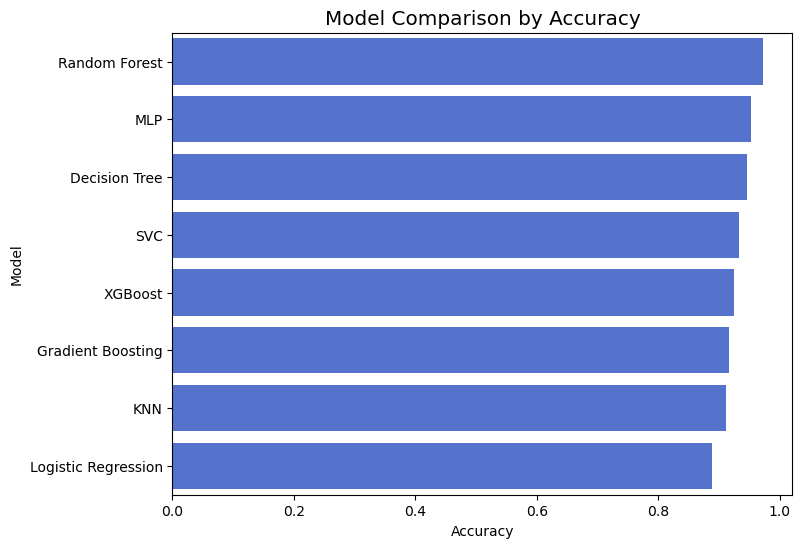

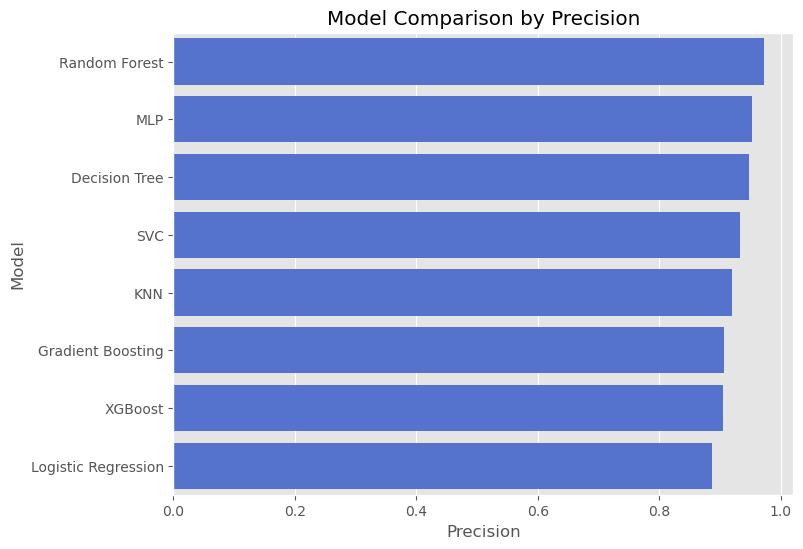

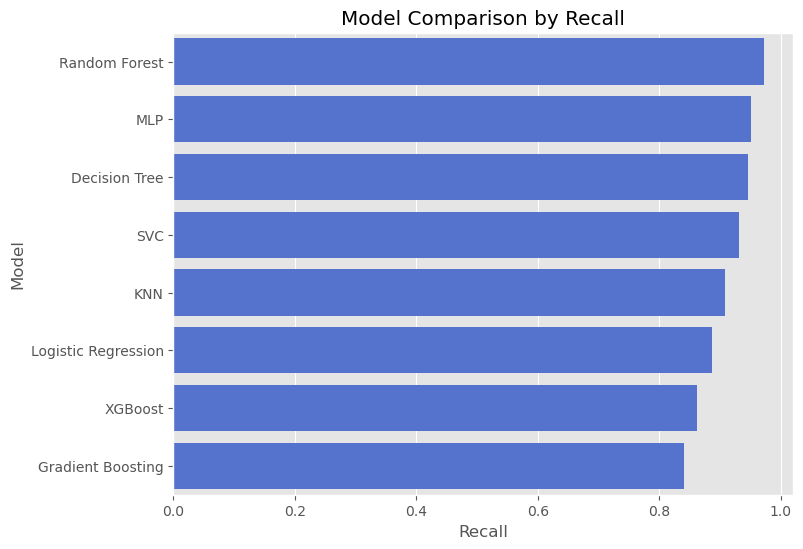

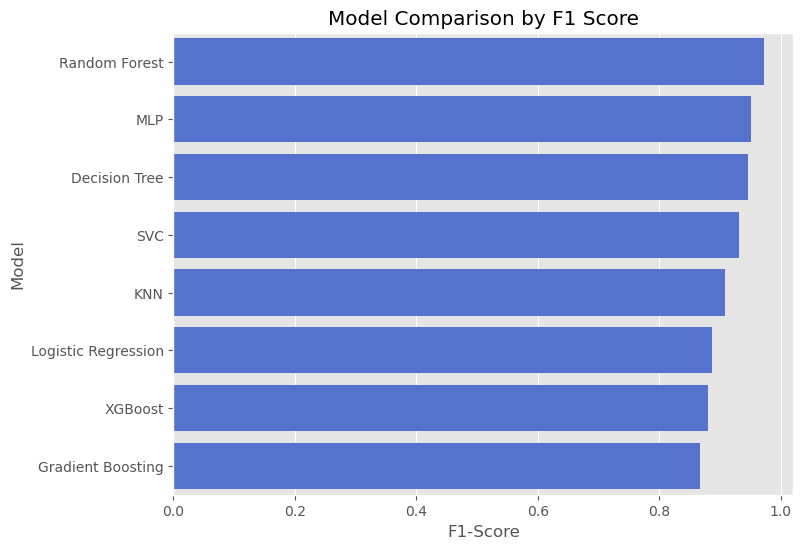

In [14]:
# Plot metrics horizontally

# Accuracy
plt.figure(figsize=(8, 6))
sns.barplot(data=metrics_df.sort_values(by='Accuracy', ascending=False), y='Model', x='Accuracy', color='royalblue')
plt.style.use('ggplot')
plt.title('Model Comparison by Accuracy')
plt.show()

# Precision
plt.figure(figsize=(8, 6))
sns.barplot(data=metrics_df.sort_values(by='Precision', ascending=False), y='Model', x='Precision', color='royalblue')
plt.style.use('ggplot')
plt.title('Model Comparison by Precision')
plt.show()

# Recall
plt.figure(figsize=(8, 6))
sns.barplot(data=metrics_df.sort_values(by='Recall', ascending=False), y='Model', x='Recall', color='royalblue')
plt.style.use('ggplot')
plt.title('Model Comparison by Recall')
plt.show()

# F1 Score
plt.figure(figsize=(8, 6))
sns.barplot(data=metrics_df.sort_values(by='F1-Score', ascending=False), y='Model', x='F1-Score', color='royalblue')
plt.style.use('ggplot')
plt.title('Model Comparison by F1 Score')
plt.show()



In [15]:
# Find the name of the best model based on accuracy
best_model_name = metrics_df.loc[metrics_df['Accuracy'].idxmax(), 'Model']

In [16]:
# Print the best model name and accuracy
print(f"The best model is: {best_model_name} with an accuracy of {metrics_df['Accuracy'].max():.4f}")

The best model is: Random Forest with an accuracy of 0.9720
